In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
PI = np.pi

In [5]:
# load data fot t, s(t)
data = np.genfromtxt("Default Dataset.csv", delimiter=",")
data[:,0] = data[:,0]*1e-6
np.shape(data)

(10000, 2)

Text(0, 0.5, '$S(t)$ (counts)')

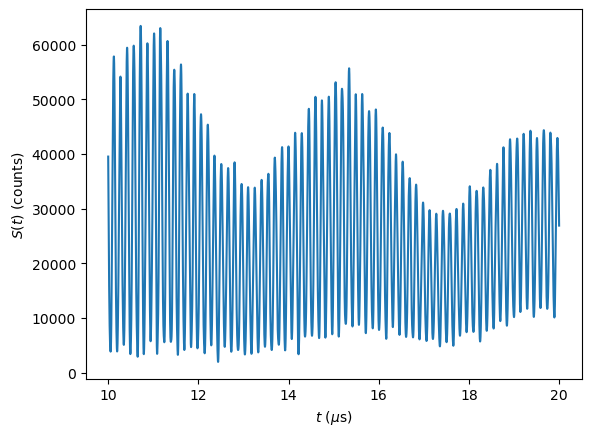

In [68]:
# plot
plt.plot(data[:,0]*1e6, data[:,1])
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('$S(t)$ (counts)')

In [33]:
# fit function to eliminate avg lower frequency and exponential decay
def f_fit(t, n, a, phi):
    tau = 64.4*1e-6
    omega = 0.229e6
    return n*np.exp(-t/tau)*(1+a*np.cos(2*PI*omega*t+phi))
popt, pcov = curve_fit(f_fit, data[:,0], data[:,1])
print(*popt)

Text(0, 0.5, 'fit to rectify lower frequency and exponential decay')

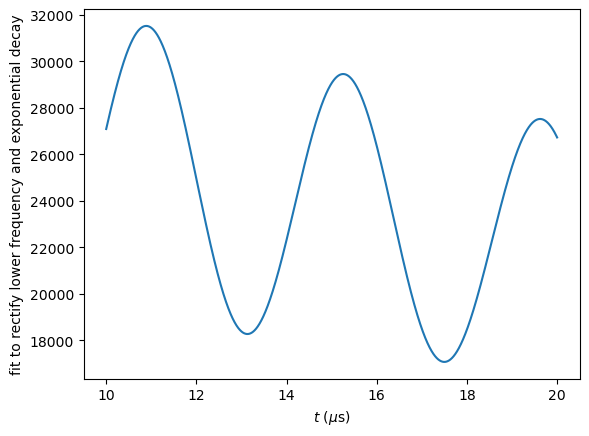

In [69]:
plt.plot(data[:,0]*1e6, f_fit(data[:,0], *popt))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('fit to rectify lower frequency and exponential decay')


In [41]:
# rectified signal
F_t_data = data[:,1]/f_fit(data[:,0], *popt)

Text(0, 0.5, '$F(t)$ rectified signal')

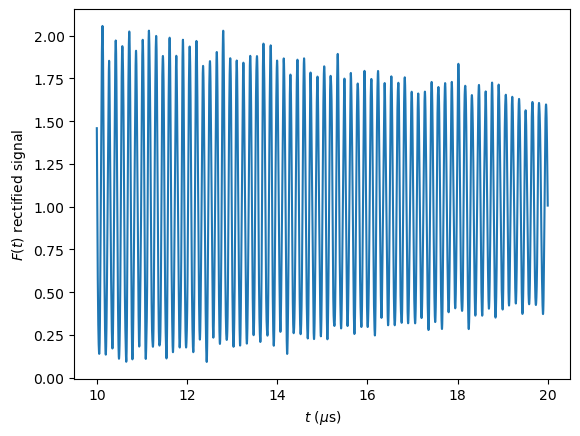

In [71]:
plt.plot(data[:,0]*1e6, F_t_data)
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('$F(t)$ rectified signal')

In [83]:
data[np.argmax(F_t_data)]

array([1.0125e-05, 5.7827e+04])

In [45]:
# Interpolate for integration
F_t_interpol = CubicSpline(data[:,0], F_t_data)

In [102]:
# Define the partial-time Fourier transform
t_m = 20e-6
t_0 = -0.e-6
def cos_fourier(f, t_s, t_0):
    t = np.linspace(t_s, t_m, 1000)
    return np.trapz(F_t_interpol(t)*np.cos(2*PI*f*(t-t_0)),t)
cos_fourier = np.vectorize(cos_fourier)

In [197]:
# Calculate cosine Fourier Image for the first peak at 10.125 us
t_s = 10.125e-6
f_range = np.linspace(6.4e6, 7e6, 1000)
phi_f = cos_fourier(f_range,10.125e-6, 0)

Text(0, 0.5, 'Re $\\Phi(f, t_s)$')

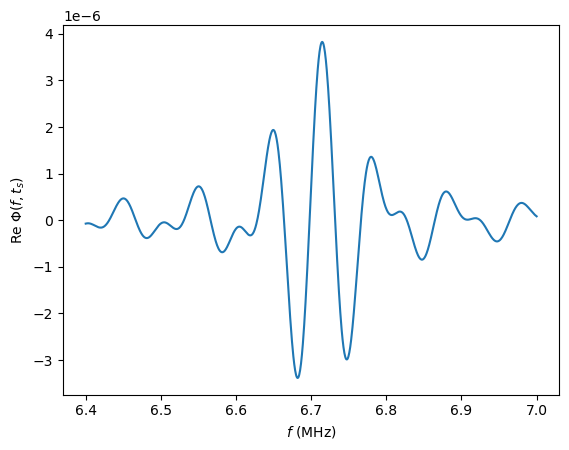

In [198]:
plt.plot(f_range*1e-6, phi_f)
plt.xlabel('$f$ (MHz)')
plt.ylabel('Re $\Phi(f, t_s)$')

Text(0, 0.5, 'Re $\\Phi(f, t_s)$')

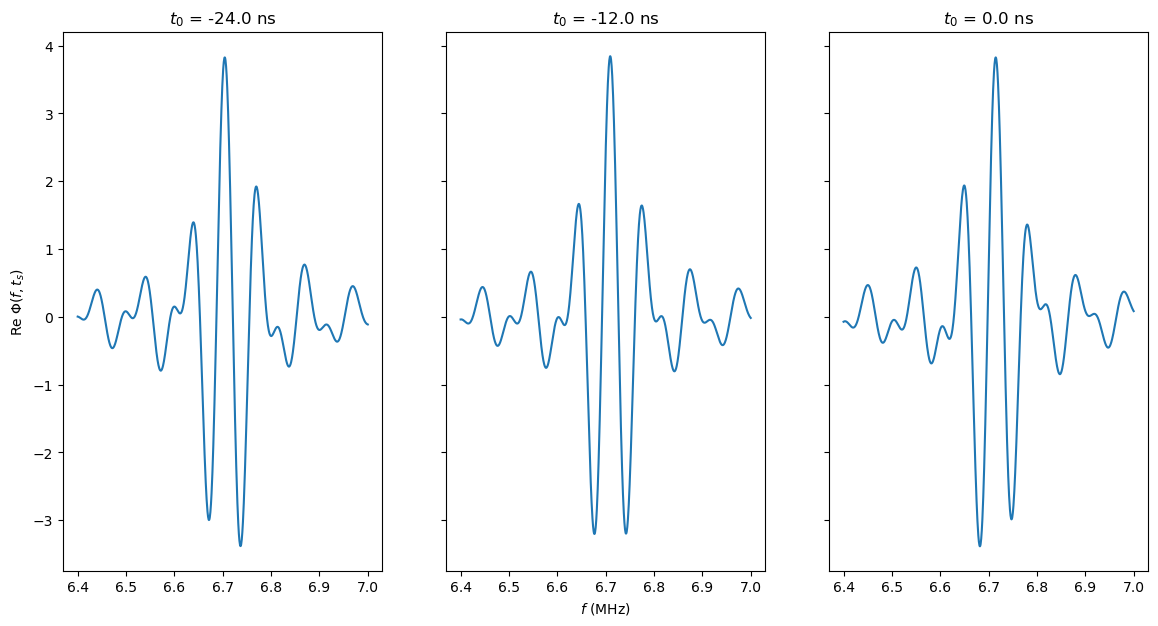

In [294]:
# find t_0 such that one gets most symmetrix peak (by eye is good enoght)
fig, ax = plt.subplots(1,3, sharey=True, figsize=(14,7))
t_0 = -24e-9
ax[0].plot(f_range*1e-6, 1e6*cos_fourier(f_range,10.125e-6, t_0))
ax[0].set_title(f'$t_0$ = {t_0*1e9} ns')
t_0 = -12e-9
ax[1].plot(f_range*1e-6, 1e6*cos_fourier(f_range,10.125e-6, t_0))
ax[1].set_title(f'$t_0$ = {t_0*1e9} ns')
t_0 = 0e-9
ax[2].plot(f_range*1e-6, 1e6*cos_fourier(f_range,10.125e-6, t_0))
ax[2].set_title(f'$t_0$ = {t_0*1e9} ns')
ax[1].set_xlabel('$f$ (MHz)')
ax[0].set_ylabel('Re $\Phi(f, t_s)$')

In [200]:
t_0 = -12e-9
phi_f = cos_fourier(f_range,10.125e-6, t_0)

(array([ 26, 127, 195, 294, 358, 461, 570, 673, 736, 840, 902]),)
[6415615.61561562 6476276.27627628 6517117.11711712 6576576.57657658
 6615015.01501502 6676876.87687688 6742342.34234234 6804204.2042042
 6842042.04204204 6904504.5045045  6941741.74174174]
[-9.89060958e-08 -4.28758522e-07 -9.95972584e-08 -7.52616058e-07
 -1.22233683e-07 -3.20306829e-06 -3.19674897e-06 -6.93219110e-08
 -8.03743488e-07 -8.72837587e-08 -4.18094207e-07]
6709309.309309309


(6.64, 6.78)

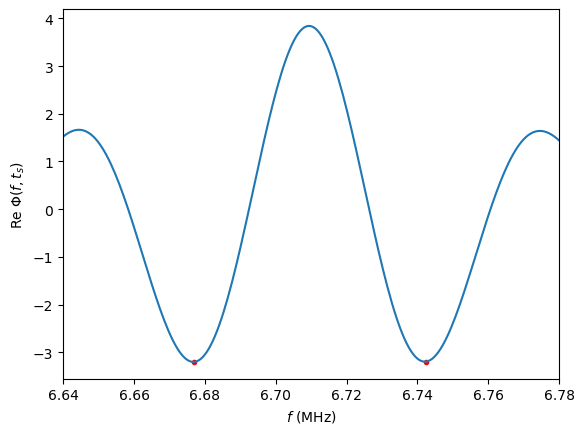

In [270]:
from scipy.signal import argrelmin
args = argrelmin(phi_f)
print(args)
print(f_range[args])
print(phi_f[args])
print(f_range[np.argmax(phi_f)])

plt.plot(f_range[461]*1e-6, phi_f[461]*1e6, 'r.')
plt.plot(f_range[570]*1e-6, phi_f[570]*1e6, 'r.')

plt.plot(f_range*1e-6, phi_f*1e6)
plt.xlabel('$f$ (MHz)')
plt.ylabel('Re $\Phi(f, t_s)$')
plt.xlim(6.64, 6.78)

Text(0.5, 1.0, 'First approximation of revolution frequency distribution')

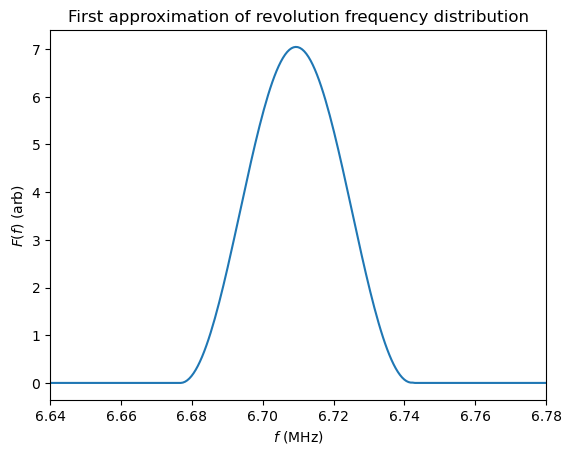

In [287]:
F_f_1st = np.where(f_range<f_range[461], phi_f[461], phi_f)
F_f_1st = np.where(f_range>f_range[570], phi_f[461], F_f_1st)
F_f_1st = F_f_1st - phi_f[461]
plt.plot(f_range*1e-6, F_f_1st*1e6)
plt.xlim(6.64, 6.78)
plt.xlabel('$f$ (MHz)')
plt.ylabel('$F(f)$ (arb)')
plt.title('First approximation of revolution frequency distribution')

In [262]:
F_f_1st_interpol = CubicSpline(f_range, F_f_1st)
def delta(f, t_s):
    fp = f_range
    return np.trapz(F_f_1st_interpol(fp)*np.sin(2*PI*(f-fp)*(t_s-t_0))/(f-fp+1e-20), fp)
delta = np.vectorize(delta)

In [263]:
delta_f = delta(f_range, t_s)

Text(0, 0.5, '$\\Delta(f, t_s)$ (arb)')

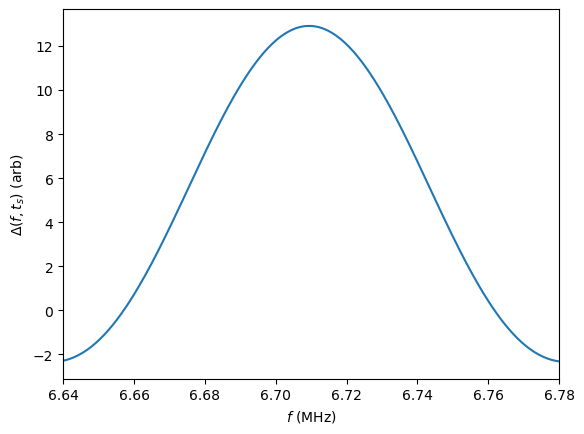

In [279]:
plt.plot(f_range*1e-6, delta_f*1e6)
plt.xlim(6.64, 6.78)
plt.xlabel('$f$ (MHz)')
plt.ylabel('$\Delta(f, t_s)$ (arb)')

Text(0.5, 1.0, 'Final accurate approximation of revolution frequency distribution')

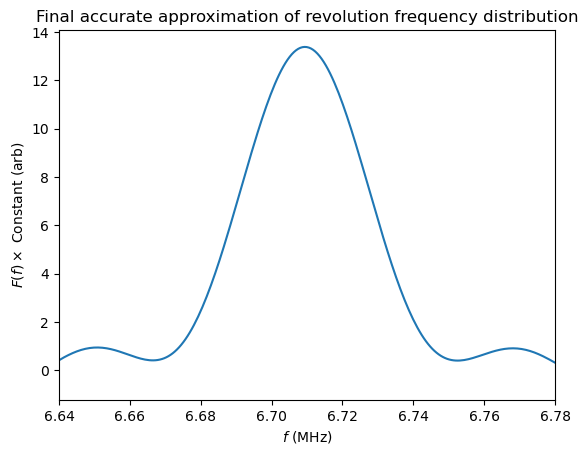

In [286]:
F_f = phi_f + delta_f*0.7+0.05e-5
plt.plot(f_range*1e-6, F_f*1e6)
plt.xlim(6.64, 6.78)
plt.xlabel('$f$ (MHz)')
plt.ylabel('$F(f)\\times$ Constant (arb)')
plt.title('Final accurate approximation of revolution frequency distribution')